# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## 1 Подготовка и исследовательский анализ данных

Импортируем библиотеки pandas, numpy, seaborn и sklearn для дальнейшей работы

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbrn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error, f1_score, accuracy_score,
                             r2_score, roc_auc_score, roc_curve, 
                             confusion_matrix)
from sklearn.utils import shuffle
!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.dummy import DummyClassifier
data = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\Churn.csv')

In [2]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Приведем названия столбцов к нужному регистру в соответствии со snake_case и изменим тип данных на корректный:

In [4]:
data.columns = data.columns.str.lower()
data.rename(columns = {'rownumber':'row_number', 'customerid':'customer_id','creditscore':'credit_score',
                       'numofproducts':'num_of_products', 'hascrcard':'has_credit_card',
                      'isactivemember':'is_active_member', 'estimatedsalary':'estimated_salary'}, inplace=True)

In [5]:
data['has_credit_card'] = data['has_credit_card'].astype(bool)
data['is_active_member'] = data['is_active_member'].astype(bool)

In [6]:
data.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure              float64
balance             float64
num_of_products       int64
has_credit_card        bool
is_active_member       bool
estimated_salary    float64
exited                int64
dtype: object

Признаки `row_number`, `customer_id` и `surname` не несут в себе информации, необходимой для дальнейшего анализа, поэтому удалим их из выборки. Проверим данные на предмет дубликатов и пропущенных значений:

In [7]:
data = data.drop(['customer_id', 'row_number', 'surname'], axis=1)
data.duplicated().sum()
data.isna().sum()

credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_credit_card       0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

В столбце `tenure` обнаружено 909 пропущенных значений. В столбце содержатся данные о том, сколько лет человек является клиентом банка. Построим общую гистограмму для всех числовых столбцов:

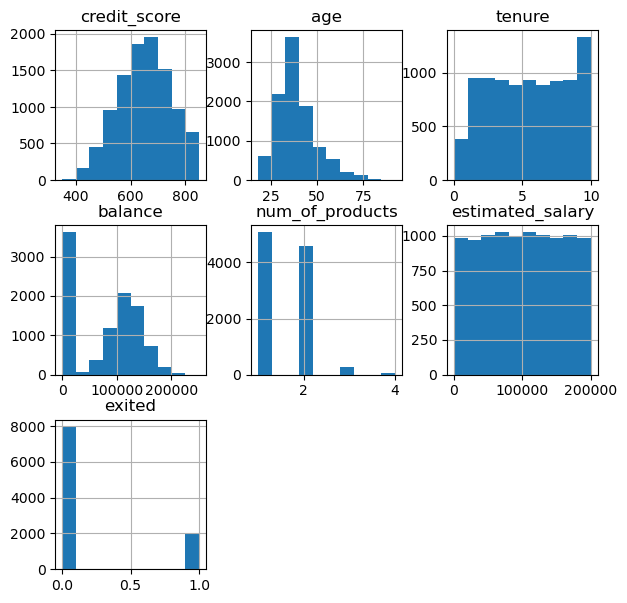

In [8]:
data.hist(figsize=(7, 7),bins=10);

In [9]:
data.describe()

,credit_score,age,tenure,balance,num_of_products,estimated_salary,exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000,1.000000


Посмотрим как распределены доли клиентов по странам, а также какие доли занимают клиенты, ушедшие из банка:

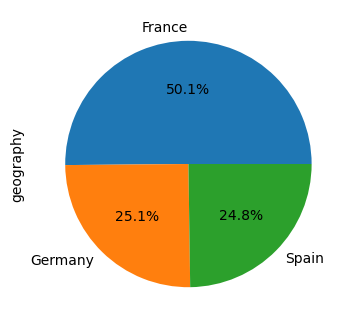

In [10]:
data['geography'].value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(4,4));

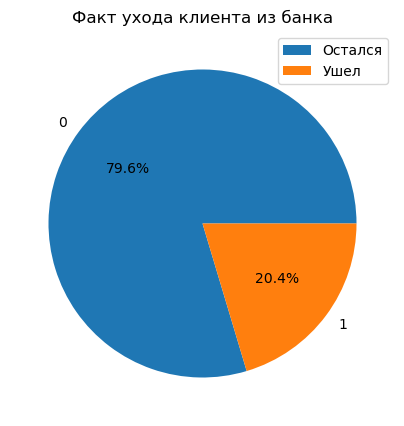

In [11]:
data['exited'].value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(5,5))
plt.legend(['Остался', 'Ушел'],fontsize=10)
plt.title('Факт ухода клиента из банка')
plt.axis('off');

На диаграмах видно, что 50% клиентов из Франции, а доля ушедших составляет 20%. Определим признаки наиболее влиющие на уход клиентов из банков

In [12]:
data.corr()

,credit_score,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited
credit_score,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
num_of_products,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
has_credit_card,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
is_active_member,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


Наиболее коррелирующий с фактом ухода из банка признак - это возвраст клиентов, меньше всего на факт ухода влияет наличие кредитной карты у клиенты. Дополнительно проверим, клиенты каких стран и гендеров чаще уходили из банка.

In [13]:
geography = data.pivot_table(index='geography', values='exited', aggfunc=['count', 'mean'])
geography.columns = ('count', 'mean')
geography

,count,mean
geography,,
France,5014,0.161548
Germany,2509,0.324432
Spain,2477,0.166734


In [14]:
gender = data.pivot_table(index='gender', values='exited', aggfunc=['count', 'mean'])
gender.columns = ('count', 'mean')
gender

,count,mean
gender,,
Female,4543,0.250715
Male,5457,0.164559


Жители Германии значительно чаще уходили из банка (32.4%), при этом с одинаковой частотой уходили из банка жители Испании (16.1%) и Франции(16.7%). Также из данных следует, что женщины чаще уходили из банка, чем мужчины. Теперь рассмотрим наиболее коррелирующий с фактом ухода признак - возраст.

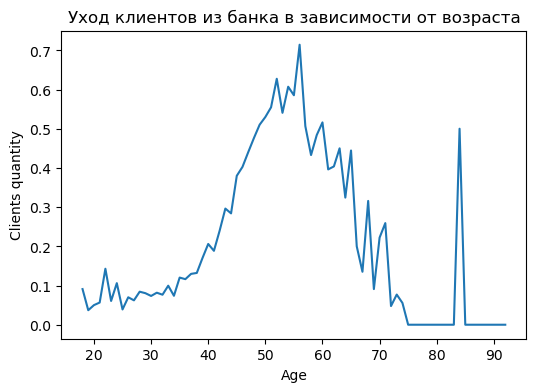

In [15]:
age = data.groupby('age')['exited'].mean()
age.plot(figsize = (6,4))
plt.xlabel('Age')
plt.ylabel('Clients quantity')
plt.title('Уход клиентов из банка в зависимости от возраста');

График наглядно показывает, что более взрослые люди (старше 45 лет) чаще уходят из банка, также стоит отметить пик ухода из банков в возрасте 85 лет.

Преобразуем категориальные признаки с помощью метода OHE, также добавим в категориальные признаки столбец `tenure` (пропущенные значения будут отдельно, так как заменять их чем-либо нелогично, неизвестно по какой причине были произведены эти пропуски)

In [16]:
data['tenure'] = data['tenure'].astype('object')
data = pd.get_dummies(data, drop_first=True)

C:\Users\Julia\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


Выведем данные после всех преобразований

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   balance            10000 non-null  float64
 3   num_of_products    10000 non-null  int64  
 4   has_credit_card    10000 non-null  bool   
 5   is_active_member   10000 non-null  bool   
 6   estimated_salary   10000 non-null  float64
 7   exited             10000 non-null  int64  
 8   geography_Germany  10000 non-null  uint8  
 9   geography_Spain    10000 non-null  uint8  
 10  gender_Male        10000 non-null  uint8  
 11  tenure_1.0         10000 non-null  uint8  
 12  tenure_2.0         10000 non-null  uint8  
 13  tenure_3.0         10000 non-null  uint8  
 14  tenure_4.0         10000 non-null  uint8  
 15  tenure_5.0         10000 non-null  uint8  
 16  tenure_6.0         1000

In [18]:
data.describe()

,credit_score,age,balance,num_of_products,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male,tenure_1.0,tenure_2.0,tenure_3.0,tenure_4.0,tenure_5.0,tenure_6.0,tenure_7.0,tenure_8.0,tenure_9.0,tenure_10.0
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000
mean,650.528800,38.921800,76485.889288,1.530200,100090.239881,0.203700,0.250900,0.247700,0.545700,0.095200,0.09500,0.092800,0.088500,0.092700,0.088100,0.092500,0.093300,0.0882,0.044600
std,96.653299,10.487806,62397.405202,0.581654,57510.492818,0.402769,0.433553,0.431698,0.497932,0.293506,0.29323,0.290166,0.284035,0.290026,0.283454,0.289745,0.290867,0.2836,0.206434
min,350.000000,18.000000,0.000000,1.000000,11.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
25%,584.000000,32.000000,0.000000,1.000000,51002.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
50%,652.000000,37.000000,97198.540000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
75%,718.000000,44.000000,127644.240000,2.000000,149388.247500,0.000000,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
max,850.000000,92.000000,250898.090000,4.000000,199992.480000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000


**Вывод:**
- дубликаты в данных не найдены, но есть пропущенные значения в столбце tenure
- в выборке представлены данные, в которых 79,6% клиентов продолжают оставаться клиентами банками, а 20,4% клиентов ушли из банка
- Клиентами банка преимущественно являются жители Франции (50,1%), а также Германии (25,1%) и Испании (24,8%)
- информация, содержащаяся в признаках столбцов row_number, customer_id и surname не пригодится нам в построении моделей, поэтому мы избавились от данных столбцов
- применили масштабирование к числовым признакам
- использовали метод One-Hot Encoding для преобразования категориальных признаков

## 2 Исследование задачи

Выведем распределение данных в столбце exited в виде таблицы

In [19]:
data['exited'].value_counts()/len(data['exited'])*100

0    79.63
1    20.37
Name: exited, dtype: float64

20% клиентов ушли из банка, 80% остаются клиентами банка. Классы не сбалансированы. Разделим данные на обучающую, валидационную и тестовую выборки (3:1:1, 60% обучающая выборка и по 20% валидационная и тестовая).

In [20]:
data_train, data_train_one = train_test_split(data, test_size=0.4, random_state=12345)
data_test, data_valid = train_test_split(data_train_one, test_size=0.5, random_state=12345)

Проверим размеры получившихся выборок:

In [21]:
print(f'Размер обучающей выборки: {len (data_train) / len(data):.0%}')
print(f'Размер валидационной выборки: {len (data_valid) / len(data):.0%}')
print(f'Размер тестовой выборки: {len (data_test) / len(data):.0%}')

Размер обучающей выборки: 60%
Размер валидационной выборки: 20%
Размер тестовой выборки: 20%


Сохраним признаки в переменной features, а целевой признак (exited) в переменной target

In [22]:
target_train = data_train['exited']
features_train = data_train.drop('exited', axis=1)
target_valid = data_valid['exited']
features_valid = data_valid.drop('exited', axis=1)
target_test = data_test['exited']
features_test = data_test.drop('exited', axis=1)

Теперь применим масштабирование с помощью метода StandardScaler к числовым признакам `credit_score`, `age`, `balance`, `estimated_salary`

In [23]:
numeric = ['credit_score', 'age', 'balance', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Данные, содержащиеся в признаке exited категориальные, соответственно будем использовать модели классификации. На данном этапе обучим модели не учитывая дисбаланс классов. 

Рассмотрим DecisionTreeClassifier. Выделим гиперпараметры для настройки дерева решений: max_depth, min_sample_leaf. Для проверки качества модели используем f1_score и roc_auc.

In [24]:
best_depth = 0
best_leaf = 0
best_f1 = 0
for depth in range(2,16):
    for leaf in range(2,10):
        model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=leaf)
        model_dt.fit(features_train, target_train)
        predictions_valid_dt = model_dt.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid_dt)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_leaf = leaf
print('F1 лучшей модели:', best_f1)
print('Глубина дерева:', best_depth)
print('Минимальное количество примеров для разделения:', best_leaf)

F1 лучшей модели: 0.5541838134430728
Глубина дерева: 10
Минимальное количество примеров для разделения: 8


In [25]:
probabilities_valid = model_dt.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print('Площадь ROC-кривой:', roc_auc)

Площадь ROC-кривой: 0.7963897396229187


F1 равна 0.55, что не достаточно для целевого показателя 0.59, дополнительно посчитали roc_auc, который равен 0.80

Рассмотрим LogisticRegression. Выделим гиперпараметры для настройки дерева решений: solver и max_iter. Для проверки качества модели используем f1_score и roc_auc_score.

In [26]:
best_f1_lr = 0
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_lr.fit(features_train, target_train)
predictions_valid_lr = model_lr.predict(features_valid)
f1_lr = f1_score(target_valid, predictions_valid_lr)
if f1_lr > best_f1_lr:
    best_f1_lr = f1_lr
print('F1 лучшей модели:', best_f1_lr)

F1 лучшей модели: 0.2777777777777778


In [27]:
probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print('Площадь ROC-кривой:', roc_auc)

Площадь ROC-кривой: 0.7374042643136938


F1 логистической регрессии значительно ниже модели дерева решений и равна 0.27, дополнительно посчитали roc_auc, который тоже ниже и равен 0.74

Рассмотрим RandomForestClassifier. Для проверки качества модели используем f1_score и roc_auc.

In [28]:
best_depth_rf = 0
best_estimator_rf = 0
best_f1_rf = 0
for depth in range(2,25):
    for estimator in range(40,120,10):
        model_rf = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimator, min_samples_leaf=5)
        model_rf.fit(features_train, target_train)
        predictions_valid_rf = model_rf.predict(features_valid)
        f1_rf = f1_score(target_valid, predictions_valid_rf)
        if f1_rf > best_f1_rf:
            best_f1_rf = f1_rf
            best_depth_rf = depth
            best_estimator_rf = estimator
print('F1 лучшей модели:', best_f1_rf)
print('Глубина дерева:', best_depth_rf)
print('Количество деревьев:', best_estimator_rf)

F1 лучшей модели: 0.5150078988941549
Глубина дерева: 18
Количество деревьев: 40


In [29]:
probabilities_valid = model_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print('Площадь ROC-кривой:', roc_auc)

Площадь ROC-кривой: 0.8566719284753795


F1 случайного леса равна 0.51, что практически равно результату дерева решений и также недостаточно до целевого показателя, дополнительно посчитали roc_auc, который равен 0.88

**Вывод:** лучший результат на несбалансированной выборке показали модели RandomForestClassifier (f1 0.51, roc_auc 0.86) и DecisionTreeClassifier(f1 0.55, roc_auc 0.80). Худший результат показала модель логистической регрессии с f1 равным 0.27 и roc_auc 0.73. В дальнейшем будем рассматривать две наиболее успешные модели.

Повысим результаты метрик с помощью решения проблемы дисбаланса классов.

## 3 Борьба с дисбалансом

Для решения проблемы дисбаланса, взвесим классы (class_weight) на моделях дерева решений и случайного леса, возможно это увеличит показатели f1 и roc_auc

In [30]:
best_depth = 0
best_leaf = 0
best_f1 = 0
for depth in range(2,16):
    for leaf in range(2,20):
        model_balanced_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=leaf,
                                                   class_weight='balanced')
        model_balanced_dt.fit(features_train, target_train)
        predicted_valid_balanced_dt = model_balanced_dt.predict(features_valid)
        f1_balanced = f1_score(target_valid, predicted_valid_balanced_dt)
        if f1_balanced > best_f1:
            best_f1 = f1_balanced
            best_depth = depth
            best_leaf = leaf
print('Decision Tree')            
print('F1 лучшей модели на сбалансированной выборке:', best_f1)
print('Глубина дерева:', best_depth)
print('Минимальное количество примеров для разделения:', best_leaf)

Decision Tree
F1 лучшей модели на сбалансированной выборке: 0.5968688845401174
Глубина дерева: 7
Минимальное количество примеров для разделения: 17


In [31]:
probabilities_balanced_valid = model_balanced_dt.predict_proba(features_valid)
probabilities_one_balanced_valid = probabilities_balanced_valid[:, 1]
roc_auc_balanced_dt = roc_auc_score(target_valid, probabilities_one_balanced_valid)
print('Площадь ROC-кривой:', roc_auc_balanced_dt)

Площадь ROC-кривой: 0.8209448469503247


In [32]:
best_depth_rf = 0
best_estimator_rf = 0
best_f1_rf = 0
for depth in range(2,25):
    for estimator in range(40,120,10):
        model_balanced_rf = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimator, 
                                                   min_samples_leaf=5, class_weight='balanced')
        model_balanced_rf.fit(features_train, target_train)
        predicted_valid_balanced_rf = model_balanced_rf.predict(features_valid)
        f1_rf_balanced = f1_score(target_valid, predicted_valid_balanced_rf)
        if f1_rf_balanced > best_f1_rf:
            best_f1_rf = f1_rf_balanced
            best_depth_rf = depth
            best_estimator_rf = estimator
print('Random Forest')
print('F1 лучшей модели на сбалансированной выборке:', best_f1_rf)
print('Глубина дерева:', best_depth_rf)
print('Количество деревьев:', best_estimator_rf)

Random Forest
F1 лучшей модели на сбалансированной выборке: 0.6252873563218392
Глубина дерева: 19
Количество деревьев: 70


In [33]:
probabilities_balanced_valid_rf = model_balanced_rf.predict_proba(features_valid)
probabilities_one_balanced_valid_rf = probabilities_balanced_valid_rf[:, 1]
roc_auc_balanced_rf = roc_auc_score(target_valid, probabilities_one_balanced_valid_rf)
print('Площадь ROC-кривой:', roc_auc_balanced_rf)

Площадь ROC-кривой: 0.8545597095361662


Взвешивание классов увеличило результаты метрик модели дерева решений (F1 0.60 , roc_auc 0.82), и результаты случайного леса  (f1 0.62, roc_auc 0.84)

Уравновесим выборку с помощью оверсеплинга и андерсэмплинга, посчитаем значение F1 и roc_auc для моделей дерева решений и случайного леса

In [34]:
features_oversampled, target_oversampled = SMOTE(random_state=123).fit_resample(features_train, target_train)
target_oversampled.value_counts()

0    4804
1    4804
Name: exited, dtype: int64

Дерево решений:

In [35]:
best_depth = 0
best_leaf = 0
best_f1 = 0
for depth in range(2,16):
    for leaf in range(2,20):
        model_oversampled_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=leaf, 
                                                      class_weight = 'balanced')
        model_oversampled_dt.fit(features_oversampled, target_oversampled)
        predicted_valid_oversampled_dt = model_oversampled_dt.predict(features_valid)
        f1_oversampled = f1_score(target_valid, predicted_valid_oversampled_dt)
        if f1_oversampled > best_f1:
            best_f1 = f1_oversampled
            best_depth = depth
            best_leaf = leaf
print('Decision Tree oversample')            
print('F1 лучшей модели:', best_f1)
print('Глубина дерева:', best_depth)
print('Минимальное количество примеров для разделения:', best_leaf)

Decision Tree oversample
F1 лучшей модели: 0.5781710914454278
Глубина дерева: 6
Минимальное количество примеров для разделения: 11


In [36]:
probabilities_oversampled_valid = model_oversampled_dt.predict_proba(features_valid)
probabilities_one_oversampled_valid = probabilities_oversampled_valid[:, 1]
roc_auc_oversampled_dt = roc_auc_score(target_valid, probabilities_one_oversampled_valid)
print('Площадь ROC-кривой:', roc_auc_oversampled_dt)

Площадь ROC-кривой: 0.797063580938161


Случайный лес:

In [37]:
best_depth_rf = 0
best_estimator_rf = 0
best_f1_rf = 0
for depth in range(2,25):
    for estimator in range(40,120,10):
        model_oversampled_rf = RandomForestClassifier(random_state=12345, n_estimators=estimator, max_depth=depth,
                                                      min_samples_leaf=5, class_weight = 'balanced')
        model_oversampled_rf.fit(features_oversampled, target_oversampled)
        predicted_valid_oversampled_rf = model_oversampled_rf.predict(features_valid)
        f1_rf_oversampled = f1_score(target_valid, predicted_valid_oversampled_rf)
        if f1_rf_oversampled > best_f1_rf:
            best_f1_rf = f1_rf_oversampled
            best_depth_rf = depth
            best_estimator_rf = estimator
print('Random Forest oversample')
print('F1 лучшей модели на сбалансированной выборке:', best_f1_rf)
print('Глубина дерева:', best_depth_rf)
print('Количество деревьев:', best_estimator_rf)

Random Forest oversample
F1 лучшей модели на сбалансированной выборке: 0.6178343949044586
Глубина дерева: 11
Количество деревьев: 70


In [38]:
probabilities_oversampled_valid_rf = model_oversampled_rf.predict_proba(features_valid)
probabilities_one_oversampled_valid_rf = probabilities_oversampled_valid_rf[:, 1]
roc_auc_oversampled_rf = roc_auc_score(target_valid, probabilities_one_oversampled_valid_rf)
print('Площадь ROC-кривой:', roc_auc_oversampled_rf)

Площадь ROC-кривой: 0.8459969028784041


In [39]:
random_undersampler = RandomUnderSampler()
features_undersampled, target_undersampled = random_undersampler.fit_resample(features_train, target_train)
target_undersampled.value_counts()

0    1196
1    1196
Name: exited, dtype: int64

Дерево решений:

In [40]:
best_depth = 0
best_leaf = 0
best_f1 = 0
for depth in range(2,16):
    for leaf in range(2,20):
        model_undersampled_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=leaf, 
                                                      class_weight = 'balanced')
        model_undersampled_dt.fit(features_undersampled, target_undersampled)
        predicted_valid_undersampled_dt = model_undersampled_dt.predict(features_valid)
        f1_undersampled = f1_score(target_valid, predicted_valid_undersampled_dt)
        if f1_undersampled > best_f1:
            best_f1 = f1_undersampled
            best_depth = depth
            best_leaf = leaf
print('Decision Tree undersample')            
print('F1 лучшей модели:', best_f1)
print('Глубина дерева:', best_depth)
print('Минимальное количество примеров для разделения:', best_leaf)

Decision Tree undersample
F1 лучшей модели: 0.5992714025500911
Глубина дерева: 5
Минимальное количество примеров для разделения: 9


In [41]:
probabilities_undersampled_valid = model_undersampled_dt.predict_proba(features_valid)
probabilities_one_undersampled_valid = probabilities_undersampled_valid[:, 1]
roc_auc_undersampled_dt = roc_auc_score(target_valid, probabilities_one_undersampled_valid)
print('Площадь ROC-кривой:', roc_auc_undersampled_dt)

Площадь ROC-кривой: 0.8293120222585002


Случайный лес:

In [42]:
best_depth_rf = 0
best_estimator_rf = 0
best_f1_rf = 0
for depth in range(2,25):
    for estimator in range(40,120,10):
        model_undersampled_rf = RandomForestClassifier(random_state=12345, n_estimators=estimator, max_depth=depth,
                                                      min_samples_leaf=5, class_weight = 'balanced')
        model_undersampled_rf.fit(features_undersampled, target_undersampled)
        predicted_valid_undersampled_rf = model_undersampled_rf.predict(features_valid)
        f1_rf_undersampled = f1_score(target_valid, predicted_valid_undersampled_rf)
        if f1_rf_undersampled > best_f1_rf:
            best_f1_rf = f1_rf_undersampled
            best_depth_rf = depth
            best_estimator_rf = estimator
print('Random Forest undersample')
print('F1 лучшей модели:', best_f1_rf)
print('Глубина дерева:', best_depth_rf)
print('Количество деревьев:', best_estimator_rf)

Random Forest undersample
F1 лучшей модели: 0.6018691588785047
Глубина дерева: 18
Количество деревьев: 70


In [43]:
probabilities_undersampled_valid_rf = model_undersampled_rf.predict_proba(features_valid)
probabilities_one_undersampled_valid_rf = probabilities_undersampled_valid_rf[:, 1]
roc_auc_undersampled_rf = roc_auc_score(target_valid, probabilities_one_undersampled_valid_rf)
print('Площадь ROC-кривой:', roc_auc_undersampled_rf)

Площадь ROC-кривой: 0.8485723408752591


**Вывод:**
- с помощью взвешивания классов (class_weight='balanced') удалось достичь нужных результатов метрик модели дерева решений (F1 0.59 , roc_auc 0.82), и результатов случайного леса (f1 0.625, roc_auc 0.85)
- с помощью увеличения классов результаты метрик дерева решений немного хуже (F1 0.58 , roc_auc 0.80), а результатов случайного леса примерно такие же как и при взвешивании (f1 0.617, roc_auc 0.84)
- с помощью уменьшения классов результаты метрик дерева решений немного хуже (F1 0.60 , roc_auc 0.83), а результатов случайного леса примерно такие же как и при взвешивании (f1 0.60, roc_auc 0.84)
- лучшие результаты метрики F1 получила модель случайного леса на сбалансированной выборке при взвешивании классов (class_weight='balanced') (f1 0.62, roc_auc 0.85)

Тестировать будем модель случайного леса, так как ее точность f1 выше, чем f1 дерева решений. При этом стоит отметить, по скорости модель случайного леса немного уступает модели дерева решений.

## 4 Тестирование модели

Протестируем модель случайного леса со сбалансированными классами (class_weight='balanced') посчитанными ранее, дополнительно вычислим метрики f1 и roc_auc на тестовой выборке

In [44]:
model_balanced_rf.fit(features_train, target_train)
predicted_test_rf = model_balanced_rf.predict(features_test)
print('F1 Random Forest на тестовой выборке:', f1_score(target_test, predicted_test_rf))
print('Roc_auc Random Forest на тестовой выборке:', roc_auc_score(target_test, predicted_test_rf))

F1 Random Forest на тестовой выборке: 0.6394557823129251
Roc_auc Random Forest на тестовой выборке: 0.7797984502688742


Построим Roc-кривую и матрицу ошибок

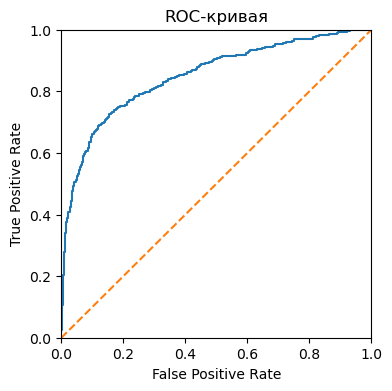

In [45]:
fpr, tpr, thresholds = roc_curve(target_test, model_balanced_rf.predict_proba(features_test)[:,1], pos_label=1)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

Text(0.5, 1.0, 'Confusion matrix')

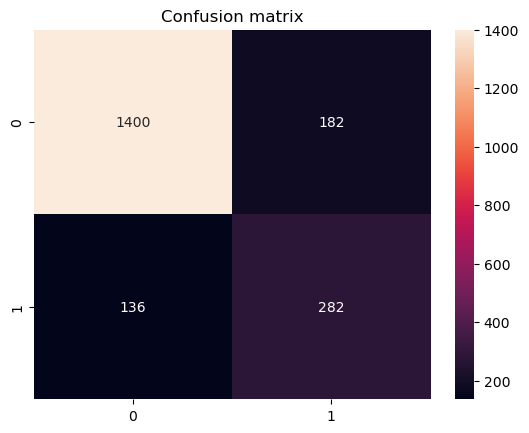

In [46]:
sbrn.heatmap(confusion_matrix(target_test, predicted_test_rf), annot=True, fmt='3.0f')
plt.title('Confusion matrix')

In [47]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
print('F1:', f1_score(dummy_model.predict(features_test), target_test))

F1: 0.3457402812241522


**Вывод:** f1 оценка на тестовой модели случайного леса дала результат 0.639, auc_roc 0.779. Roc-кривая и матрица ошибок показали хорошие результаты, это значит, что модель предсказывала не случайно и чаще отвечала верно.

**Вывод по пректу:**
- удалось достичь результат метрики f1 равный 0.639, что выше минимально установленного порога в 0.59
- в выборке представлены данные, в которых 79,6% клиентов продолжают оставаться клиентами банками, а 20,4% клиентов ушли из банка
- клиентами банка преимущественно являются жители Франции (50,1%), а также Германии (25,1%) и Испании (24,8%)
- мы применили масштабирование к числовым признакам и использовали метод One-Hot Encoding для преобразования категориальных признаков
- лучший результат на несбалансированной выборке показали модели RandomForestClassifier (f1 0.51, roc_auc 0.86) и DecisionTreeClassifier(f1 0.55, roc_auc 0.80). Худший результат показала модель логистической регрессии с f1 равным 0.27 и roc_auc 0.73. В дальнейшем будем рассматривать две наиболее успешные модели.
- с помощью взвешивания классов (class_weight='balanced') удалось достичь нужных результатов метрик модели дерева решений (F1 0.59 , roc_auc 0.82), и результатов случайного леса (f1 0.625, roc_auc 0.85)
- с помощью увеличения классов результаты метрик дерева решений немного хуже (F1 0.58 , roc_auc 0.80), а результатов случайного леса примерно такие же как и при взвешивании (f1 0.617, roc_auc 0.84)
- с помощью уменьшения классов результаты метрик дерева решений немного хуже (F1 0.60 , roc_auc 0.83), а результатов случайного леса примерно такие же как и при взвешивании (f1 0.60, roc_auc 0.84)
- лучшие результаты метрики F1 получила модель случайного леса на сбалансированной выборке при взвешивании классов (class_weight='balanced') (f1 0.62, roc_auc 0.85)
-  f1 оценка на тестовой модели случайного леса дала результат 0.639, auc_roc 0.779. Roc-кривая и матрица ошибок показали хорошие результаты, это значит, что модель предсказывала не случайно и чаще отвечала верно.